In [1]:
import os
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import cartopy

crs = cartopy.crs.PlateCarree()
import cartopy.feature as cfeature

/work/softs/vre/projets/swotce/qualification/environments/ceswot-base/develop/env/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'ucx.cuda-copy' has been deprecated; please use 'distributed.ucx.cuda_copy' instead
  warnings.warn(
/work/softs/vre/projets/swotce/qualification/environments/ceswot-base/develop/env/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'ucx.tcp' has been deprecated; please use 'distributed.ucx.tcp' instead
  warnings.warn(
/work/softs/vre/projets/swotce/qualification/environments/ceswot-base/develop/env/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'ucx.nvlink' has been deprecated; please use 'distributed.ucx.nvlink' instead
  warnings.warn(
/work/softs/vre/projets/swotce/qualification/environments/ceswot-base/develop/env/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'ucx.infiniband' has been deprecated; pleas

---

## L3 inspection

In [2]:
swot_l3_root = "/work/HELPDESK_SWOTLR/commun/data/swot/L3_LR_SSH/reprocessing_20230726/"
swot_l3_root = "/work/HELPDESK_SWOTLR/commun/data/swot/L3_LR_SSH/v0.1"
#swot_l3_root = "/work/HELPDESK_SWOTLR/commun/data/swot/L3_LR_SSH/v0.2"

In [3]:
# swot_basic = sorted(glob(os.path.join(swot_l3_root, "basic/SWOT_L3*.nc")))
# swot_expert = sorted(glob(os.path.join(swot_l3_root, "expert/SWOT_L3*.nc")))

# SWOT_L3_LR_SSH_Basic_578_012_20230710T150945_20230710T160051_v0.1.nc

In [4]:
def load_tree(ptype):
    files = sorted(glob(os.path.join(swot_l3_root, ptype, "SWOT_L3*.nc")))

    cycles = [int(f.split("/")[-1].split("_")[5]) for f in files]
    passes = [int(f.split("/")[-1].split("_")[6]) for f in files]
    time_start = [pd.Timestamp(f.split("/")[-1].split("_")[7]) for f in files]
    time_end = [pd.Timestamp(f.split("/")[-1].split("_")[8]) for f in files]

    cycles_unique = np.unique(cycles)
    passes_unique = np.unique(passes)

    df = pd.DataFrame(
        dict(
            file=files, cycle_id=cycles, pass_id=passes, start=time_start, end=time_end
        )
    )
    # .set_index(["cycle_id", "pass_id"])

    return df, cycles_unique, passes_unique

In [5]:
ba, cycles, passes = load_tree("basic")
ex, _, _ = load_tree("expert")

In [6]:
cycles, passes, len(cycles), len(passes)

(array([454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466,
        467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479,
        480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492,
        493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505,
        506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518,
        519, 520, 521, 522, 523, 524, 525, 528, 529, 530, 531, 532, 533,
        534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546,
        547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559,
        560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572,
        573, 574, 575, 576, 577, 578]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),
 123,
 28)

### show passes

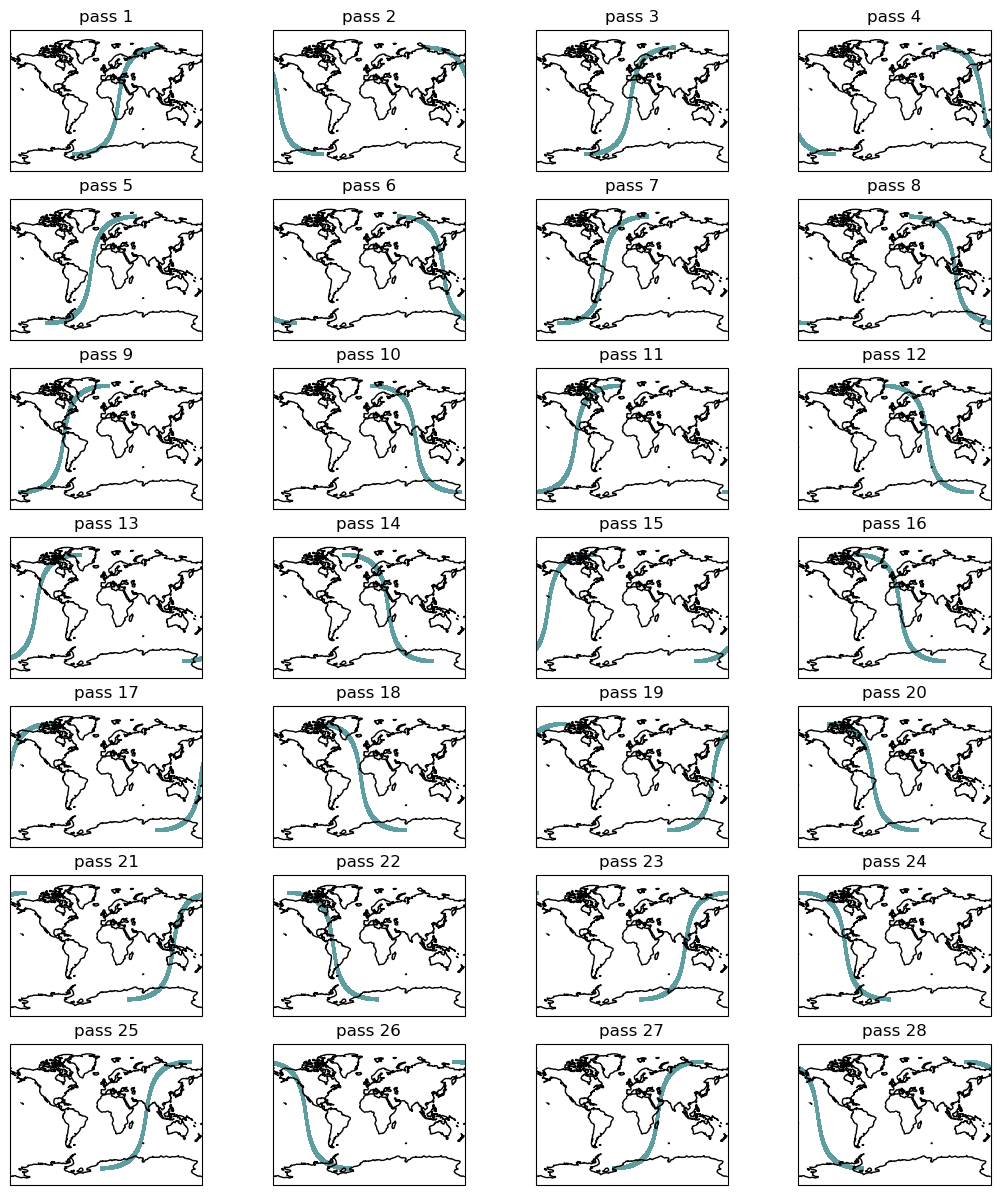

In [76]:
fig, axes = plt.subplots(
    7, 4, subplot_kw={"projection": ccrs.Miller()}, figsize=(13, 15)
)

for i, p in enumerate(passes):
    ds = xr.open_dataset(ba.loc[456, p]["file"])

    ax = axes.flatten()[i]
    ax.coastlines()
    ax.set_global()

    # ds.ssha.plot(x="longitude", y="latitude", transform=ccrs.PlateCarree)
    # _h = ax.scatter(ds.longitude, ds.latitude, c=ds.ssha, s=1, transform=ccrs.PlateCarree(), cmap="RdBu_r", vmin=-1, vmax=1)
    # plt.colorbar(_h)
    ax.scatter(
        ds.longitude, ds.latitude, c="cadetblue", s=1, transform=ccrs.PlateCarree()
    )
    ax.set_title(f"pass {p}")

### load sample data

In [7]:
def load_snapshot(df, time, pass_id, extent=None):
    f = str(
        df.reset_index()
        .set_index("pass_id")
        .loc[pass_id]
        .set_index("start")
        .loc[time]["file"]
        .values[0]
    )
    print(f)
    ds = xr.open_dataset(f, engine="netcdf4")

    if extent is not None:
        ds = geo_zoom(ds, extent)

    return ds


def geo_zoom(ds, extent):
    coords = list(ds.coords)

    _ds = ds.reset_coords().isel(num_pixels=35, drop=True)
    lon, lat = _ds.longitude, _ds.latitude
    # print(ds.longitude, lon)

    ds = (
        ds.reset_coords()
        .where(
            (lon > extent[0])
            & (lon < extent[1])
            & (lat > extent[2])
            & (lat < extent[3]),
            drop=True,
        )
        .set_coords(coords)
    )
    # ds = ds.where( ~np.isnan(ds.time), drop=True)
    return ds


def _load_area0(extent, pass_id):
    D = []

    _df = df.reset_index().set_index("pass_id").loc[pass_id].set_index("cycle_id")

    # for c in cycles_unique[:2]:
    for i, r in _df.iterrows():
        # print(c, pass_id)
        print(r)
        print(r["file"])
        ds = xr.open_dataset(r["file"])

        ds = geo_zoom(ds, extent)

        return ds
        D.append(ds)

    return D

In [8]:
# extent = (1,7, 38, 44)
extent = (0, 10, 38, 44)
extent = (4, 7, 42, 43.5)
# D = load_area(extent, 3)

ds = load_snapshot(ex, "2023-04-06", 3, extent=extent)
#ds = load_snapshot(ex, "2023-04-19", 3, extent=extent)

/work/HELPDESK_SWOTLR/commun/data/swot/L3_LR_SSH/v0.1/expert/SWOT_L3_LR_SSH_Expert_483_003_20230406T221957_20230406T231102_v0.1.nc


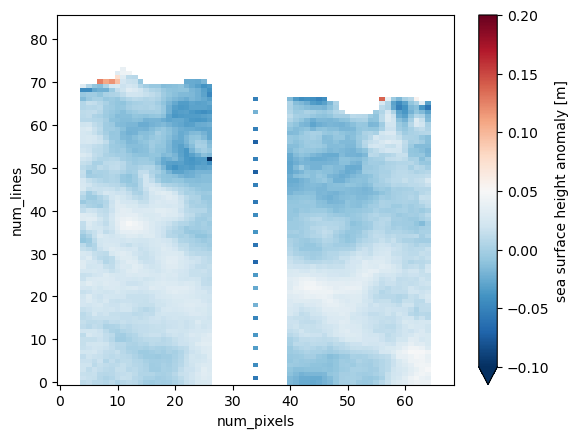

In [9]:
ds["ssha"].plot(vmin=-0.1, vmax=0.2, cmap="RdBu_r")

In [11]:
ds["ssha"]

<xarray.DataArray 'ssha' (num_lines: 86, num_pixels: 69)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    latitude   (num_lines, num_pixels) float64 42.15 42.15 42.15 ... 43.35 43.34
    longitude  (num_lines, num_pixels) float64 4.225 4.248 4.272 ... 6.317 6.341
Dimensions without coordinates: num_lines, num_pixels
Attributes:
    long_name:      sea surface height anomaly
    standard_name:  sea_surface_height_above_reference_ellipsoid
    comment:        Height of the sea surface anomaly with all corrections ap...
    units:          m

In [12]:
ds["mdt"]

<xarray.DataArray 'mdt' (num_lines: 86, num_pixels: 69)>
array([[-0.1404, -0.1412, -0.1419, ..., -0.157 , -0.1569, -0.1567],
       [-0.1404, -0.1412, -0.1419, ..., -0.1575, -0.1574, -0.1573],
       [-0.1403, -0.1411, -0.1419, ..., -0.1581, -0.158 , -0.1578],
       ...,
       [-0.06  , -0.06  , -0.06  , ..., -0.0242, -0.0243, -0.0249],
       [-0.0596, -0.0595, -0.0595, ..., -0.0259, -0.0261, -0.0265],
       [-0.0591, -0.0591, -0.0591, ..., -0.0271, -0.0273, -0.0277]])
Coordinates:
    latitude   (num_lines, num_pixels) float64 42.15 42.15 42.15 ... 43.35 43.34
    longitude  (num_lines, num_pixels) float64 4.225 4.248 4.272 ... 6.317 6.341
Dimensions without coordinates: num_lines, num_pixels
Attributes:
    comment:        The mean dynamic topography is the sea surface height abo...
    units:          m
    long_name:      mean dynamic topography
    standard_name:  mean_dynamic_topography_cnes_cls

Text(0.5, 1.0, '2023/19/04 20:55')

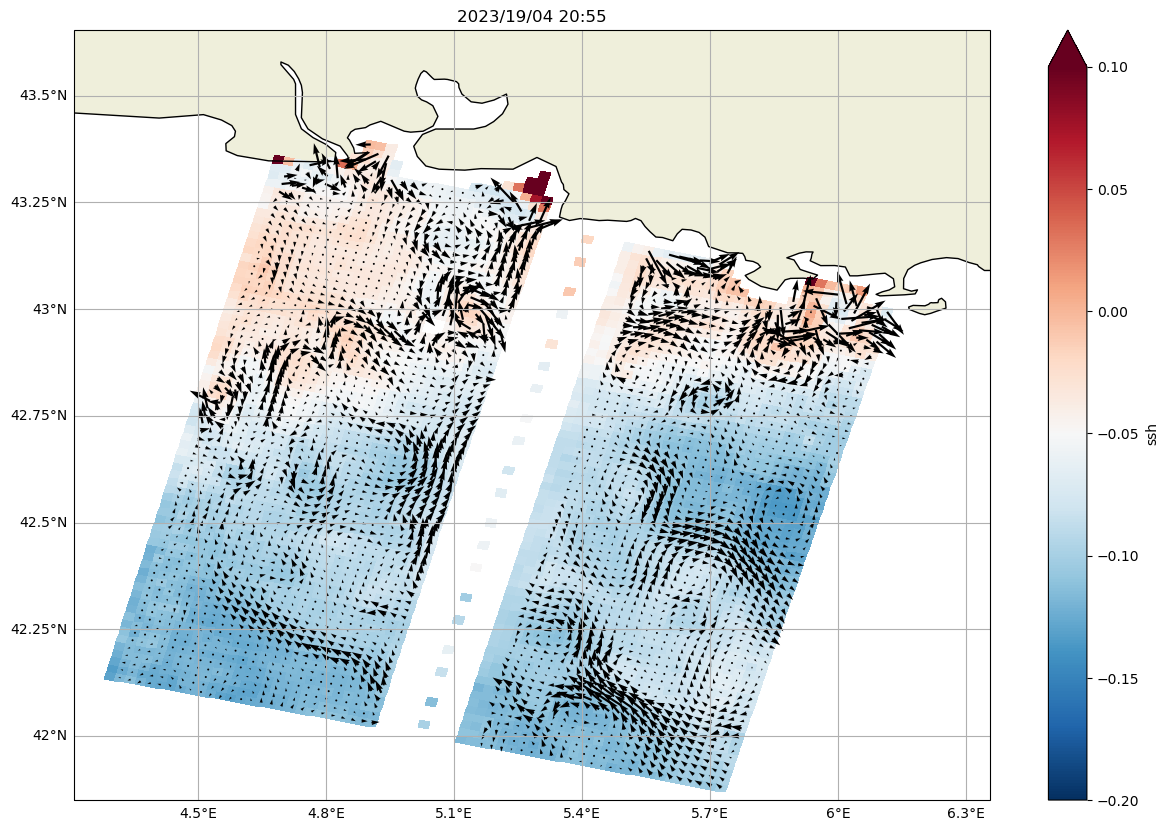

In [48]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1, projection=crs)
# ax.set_extent([80, 170, -45, 30], crs=crs)

(ds["ssha"] + ds["mdt"]).rename("ssh").plot(
    x="longitude",
    y="latitude",
    ax=ax,
    vmin=-0.2,
    vmax=0.1,
    cmap="RdBu_r",
    transform=crs,
)

ds["vel"] = np.sqrt(ds.ugos**2 + ds.vgos**2)
_ds = ds.where(ds.vel < 1)
ax.quiver(_ds.longitude, _ds.latitude, _ds.ugos, _ds.vgos, transform=crs)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND)
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.set_title(ds.time.dt.strftime("%Y/%d/%m %H:%M").values[0])

Text(0.5, 1.0, '2023/19/04 20:55')

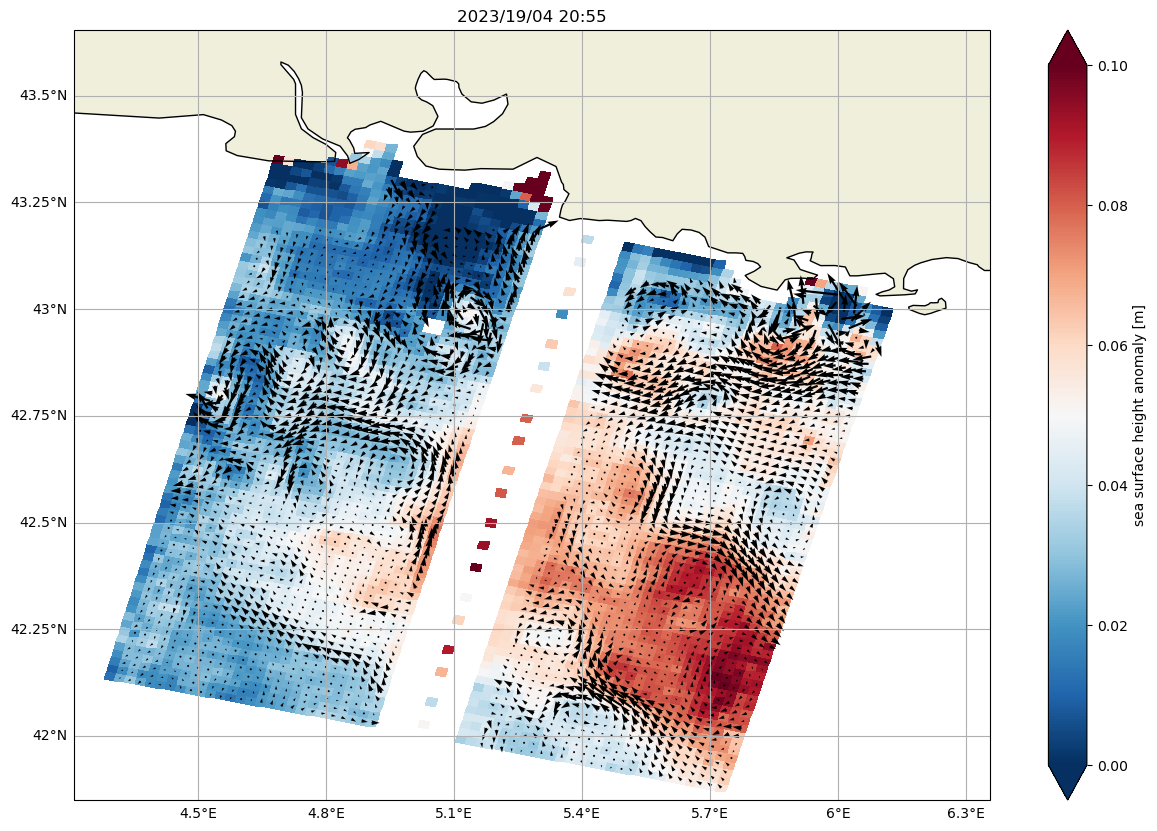

In [47]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1, projection=crs)
# ax.set_extent([80, 170, -45, 30], crs=crs)

ds["ssha"].plot(
    x="longitude", y="latitude", ax=ax, vmin=0.0, vmax=0.1, cmap="RdBu_r", transform=crs
)

ds["vel"] = np.sqrt(ds.ugos**2 + ds.vgos**2)
_ds = ds.where(ds.vel < 1)
ax.quiver(_ds.longitude, _ds.latitude, _ds.ugosa, _ds.vgosa, transform=crs)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND)
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.set_title(ds.time.dt.strftime("%Y/%d/%m %H:%M").values[0])

Text(0.5, 1.0, '2023/19/04 20:55')

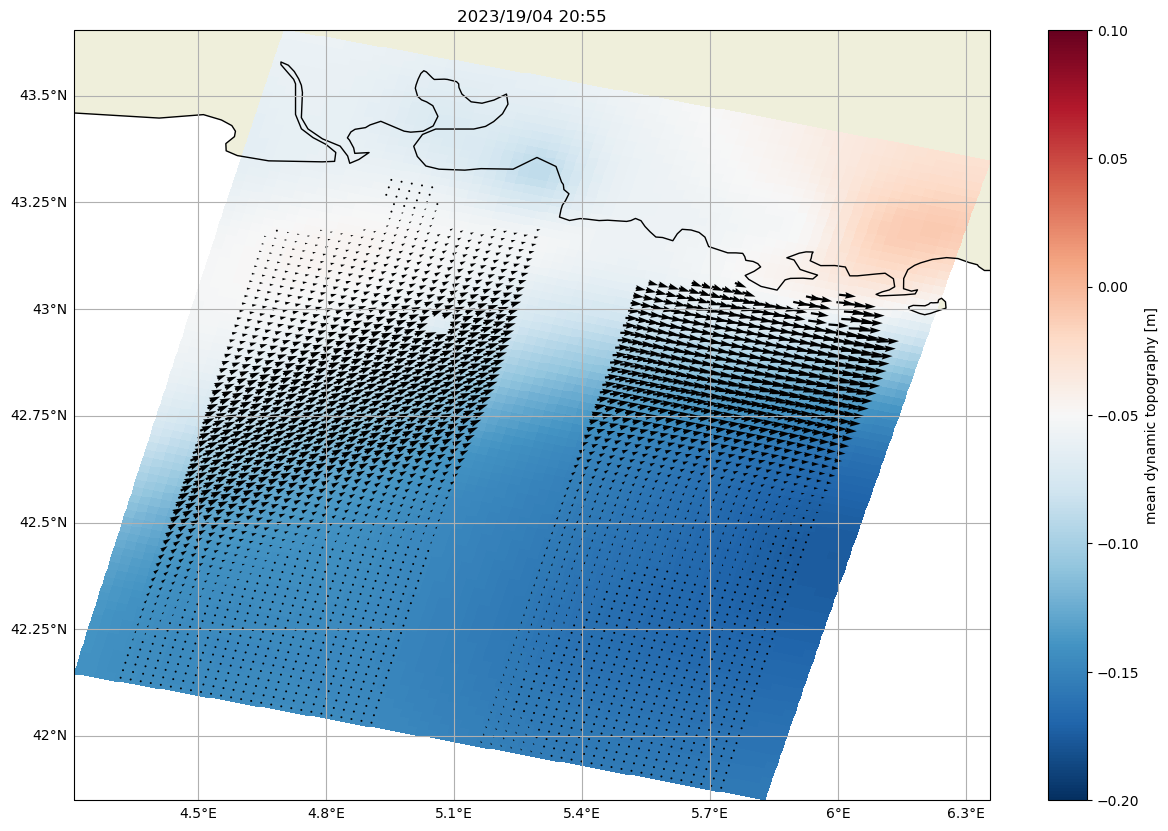

In [49]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1, projection=crs)
# ax.set_extent([80, 170, -45, 30], crs=crs)

ds["mdt"].plot(
    x="longitude",
    y="latitude",
    ax=ax,
    vmin=-0.2,
    vmax=0.1,
    cmap="RdBu_r",
    transform=crs,
)

ds["vel"] = np.sqrt(ds.ugos**2 + ds.vgos**2)
_ds = ds.where(ds.vel < 1)
ax.quiver(
    _ds.longitude,
    _ds.latitude,
    _ds.ugosa - _ds.ugos,
    _ds.vgosa - _ds.vgos,
    transform=crs,
)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND)
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.set_title(ds.time.dt.strftime("%Y/%d/%m %H:%M").values[0])

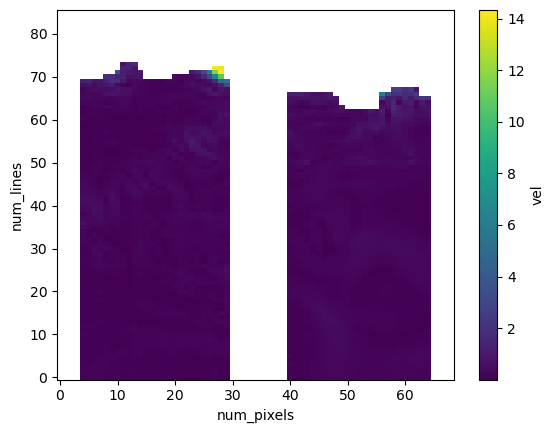

In [28]:
ds.vel.plot()

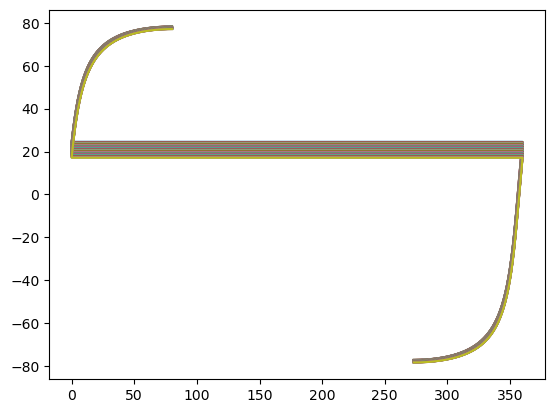

In [47]:
ds = D
fig, ax = plt.subplots(1, 1)
ax.plot(ds.longitude, ds.latitude)
# ax.set_xlim(0,10)

In [48]:
lon, lat = ds.longitude, ds.latitude

In [49]:
ds["flag"] = (
    (lon > extent[0]) & (lon < extent[1]) & (lat > extent[2]) & (lat < extent[3])
)

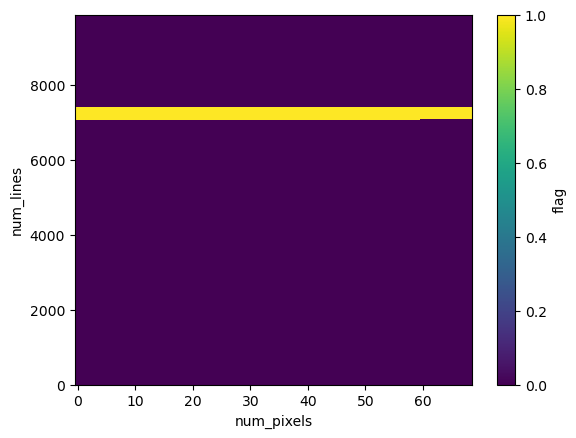

In [53]:
ds.flag.plot()

In [50]:
extent

(0, 10, 38, 44)

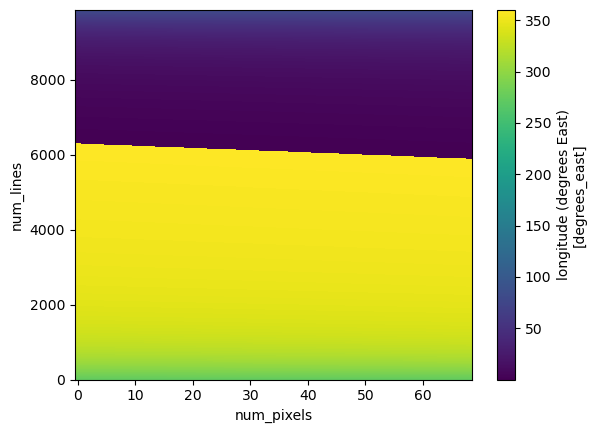

In [51]:
ds["longitude"].plot()

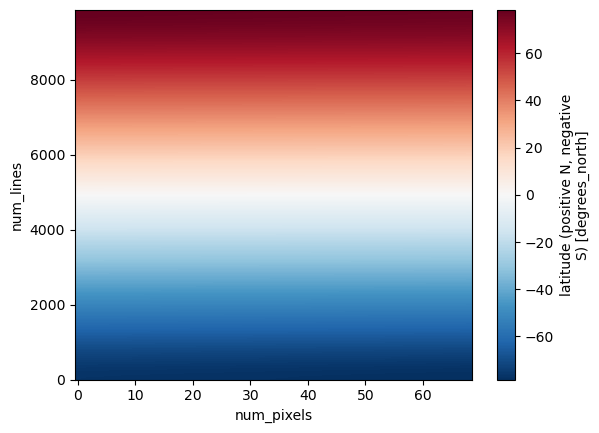

In [52]:
ds["latitude"].plot()

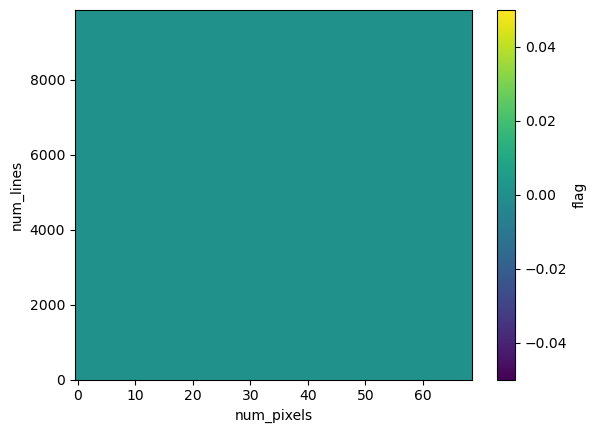

In [23]:
ds["flag"].plot()

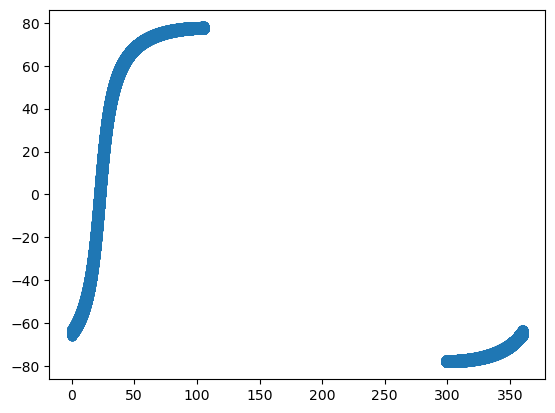

In [107]:
fig, ax = plt.subplots(1, 1)
ax.scatter(lon, lat)

In [1]:
# ds.plot.scatter("longitude", "latitude", s=1)

In [78]:
ds

<xarray.Dataset>
Dimensions:         (num_lines: 9860, num_pixels: 69, num_nadir: 1)
Coordinates:
    latitude        (num_lines, num_pixels) float64 78.27 78.25 ... -78.27
    longitude       (num_lines, num_pixels) float64 131.8 131.8 ... 298.7 298.7
Dimensions without coordinates: num_lines, num_pixels, num_nadir
Data variables:
    time            (num_lines) datetime64[ns] ...
    mdt             (num_lines, num_pixels) float64 ...
    ssha            (num_lines, num_pixels) float64 ...
    ssha_noiseless  (num_lines, num_pixels) float64 ...
    i_num_line      (num_nadir) int16 ...
    i_num_pixel     (num_nadir) int8 ...
Attributes: (12/41)
    contact:                         aviso@altimetry.fr
    creator_email:                   aviso@altimetry.fr
    creator_name:                    DUACS - Data Unification and Altimeter C...
    creator_url:                     http://aviso.altimetry.fr
    institution:                     CNES
    license:                         http://www.aviso.altimetry.fr/fileadmin/...
    ...                              ...
    time_coverage_begin:             2023-03-11T23:50:16Z
    time_coverage_end:               2023-03-12T00:41:21Z
    geospatial_lat_min:              -78.272132
    geospatial_lat_max:              78.272321
    geospatial_lon_min:              131.771603
    geospatial_lon_max:              298.717575